# Airbnb Pricing Model

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam

print(tf.__version__)

2.1.0


## Dataset de entrada

In [2]:
listings=pd.read_csv('listings.csv')
print('El dataset de entrada contiene', len(listings.columns), 'columnas', 'y', len(listings), 'filas')

El dataset de entrada contiene 92 columnas y 3818 filas


## Limpieza de los datos

In [3]:
for col in listings.columns: ##Eliminando las columnas que tienen un solo valor 
    if len(listings[col].unique()) == 1:
        listings.drop(col,inplace=True,axis=1)
        
print('Luego de remover las columnas con un valor único permanecen', len(listings.columns),'columnas')

Luego de remover las columnas con un valor único permanecen 81 columnas


In [4]:
def convert_to_numbers(dataset, column): #Eliminando $ del string y convirtiendolo en número
    dataset[column]=dataset[column].str.replace('[$,]', '').astype('float')
    return print('La columna', column, 'ha sido modificada')

Columns_to_convert=['price', 'cleaning_fee', 'extra_people', 'security_deposit']

for variable in Columns_to_convert:
    convert_to_numbers(listings, variable)


La columna price ha sido modificada
La columna cleaning_fee ha sido modificada
La columna extra_people ha sido modificada
La columna security_deposit ha sido modificada


In [5]:
def removing_percentage (dataset, column): #Eliminando % del string y convirtiendolo en número
    dataset[column]=dataset[column].str.replace('%', '').astype('float')
    print('La columna', column, 'ha sido modificada')

removing_perc=['host_acceptance_rate', 'host_response_rate']

for var in removing_perc:
    removing_percentage(listings, var)

La columna host_acceptance_rate ha sido modificada
La columna host_response_rate ha sido modificada


In [6]:
listings.cleaning_fee=listings.cleaning_fee.fillna(0) #Asumiendo que los vacios de estos campos corresponden a 0
listings.security_deposit=listings.security_deposit.fillna(0)

Se identifican y remueven las columnas que contienen un porcentaje superior de 30% de datos faltantes

In [7]:
most_missing_cols = set(listings.columns[listings.isnull().mean() > 0.30])
most_missing_cols #Columnas con un porcentaje de datos faltantes superior al 30%

{'monthly_price', 'notes', 'square_feet', 'weekly_price'}

Identificando y removiendo columnas de: urls, pricing (diferentes al target),  texto, geogràficas diferentes al vecindario y a lat-lng, diponibilidad superior a 30 dias y relacionadas con el host.

In [8]:
url_field=list(listings.filter(like='url').columns) 
other_pricing_field=list(listings.filter(like='_price').columns)
text_field=['notes','neighborhood_overview', 'host_about','transit', 'space','summary','description']
other_geo=[ 'zipcode', 'neighbourhood', 'host_name','smart_location',  'is_location_exact', 'street', 'neighbourhood_cleansed', 'city', 'state']
availability=['availability_60', 'availability_90', 'availability_365']
host=['host_verifications', 'host_total_listings_count' ,'host_has_profile_pic', 'host_location', 'host_id','host_neighbourhood','host_location', 'calculated_host_listings_count', 'host_listings_count']

In [9]:
listings=listings.drop(url_field+other_pricing_field+text_field+other_geo+availability+host+['square_feet','first_review', 'last_review'], axis=1) #Se remueven las columnas

Se adiciona el indice de polaridad de los reviews calculado con TextBlob

In [10]:
polarity=pd.read_csv('reviews_polarity.csv')
listings=listings.merge(polarity, left_on='id', right_on='listing_id', how='left') #Adicionando el indice de polaridad calculado para los reviews
listings.columns

Index(['id', 'name', 'host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_identity_verified',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'availability_30',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'reviews_per_month', 'listing_id', 'comments_polarity'],
      dtype='object')

In [11]:
listings=listings.drop(['listing_id', 'name'], axis=1)

### Eliminando los datos faltantes

In [12]:
listings=listings.dropna()

### Variables categoricas: Codificación One Hot

In [13]:
listings.columns

Index(['id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_identity_verified',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'availability_30',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'reviews_per_month', 'comments_polarity'],
      dtype='object')

In [14]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(listings)

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,comments_polarity
0,241032,2011-08-11,within a few hours,96.0,100.0,f,t,Queen Anne,47.636289,-122.371025,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,0.0,2,5.0,1,365,4 weeks ago,14,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,4.07,0.377606
1,953595,2013-02-21,within an hour,98.0,100.0,t,t,Queen Anne,47.639123,-122.365666,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,100.0,40.0,1,0.0,2,90,today,13,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,1.48,0.399665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,2015-04-13,within a few hours,99.0,100.0,f,t,Other neighborhoods,47.664295,-122.359170,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",359.0,0.0,230.0,1,0.0,3,1125,today,18,1,80.0,8.0,10.0,4.0,8.0,10.0,8.0,f,strict,f,f,0.30,0.000000
3814,8902327,2015-10-14,within an hour,100.0,100.0,f,t,Capitol Hill,47.649552,-122.318309,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",79.0,500.0,50.0,3,25.0,2,29,2 days ago,6,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate,f,f,2.00,0.391804


In [15]:
var_categorical=['host_response_time','host_identity_verified',  'host_is_superhost', 'cancellation_policy']

In [16]:
listings=pd.concat([listings, pd.get_dummies(listings['host_response_time'])], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['host_identity_verified'], prefix='identity_verified')], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['host_is_superhost'], prefix='superhost')], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['cancellation_policy'], prefix='cancellation')], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['require_guest_profile_picture'], prefix='guest_pro_pic')], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['instant_bookable'], prefix='inst_book')], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['require_guest_phone_verification'], prefix='guest_phone_ver')], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['property_type'])], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['room_type'])], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['neighbourhood_group_cleansed'])], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['bed_type'])], axis=1) 
#listings=pd.concat([listings, pd.get_dummies(listings['calendar_updated'])], axis=1) 

In [17]:
var_categorical=['host_response_time','host_identity_verified',  'host_is_superhost', 'cancellation_policy', 'neighbourhood_group_cleansed','bed_type', 
                 'require_guest_profile_picture', 'instant_bookable', 'require_guest_phone_verification', 'property_type', 'room_type',  'calendar_updated' ]
listings=listings.drop(var_categorical, axis=1)

In [18]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(listings)

,id,host_since,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,comments_polarity,a few days or more,within a day,within a few hours,within an hour,identity_verified_f,identity_verified_t,superhost_f,superhost_t,cancellation_flexible,cancellation_moderate,cancellation_strict,guest_pro_pic_f,guest_pro_pic_t,inst_book_f,inst_book_t,guest_phone_ver_f,guest_phone_ver_t,Apartment,Bed & Breakfast,Boat,Bungalow,Cabin,Camper/RV,Chalet,Condominium,Dorm,House,Loft,Other,Tent,Townhouse,Treehouse,Yurt,Entire home/apt,Private room,Shared room,Ballard,Beacon Hill,Capitol Hill,Cascade,Central Area,Delridge,Downtown,Interbay,Lake City,Magnolia,Northgate,Other neighborhoods,Queen Anne,Rainier Valley,Seward Park,University District,West Seattle,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
0,241032,2011-08-11,96.0,100.0,47.636289,-122.371025,4,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,0.0,2,5.0,1,365,14,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,4.07,0.377606,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,953595,2013-02-21,98.0,100.0,47.639123,-122.365666,4,1.0,1.0,1.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,100.0,40.0,1,0.0,2,90,13,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1.48,0.399665,0,0,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,2015-04-13,99.0,100.0,47.664295,-122.359170,6,2.0,3.0,3.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",359.0,0.0,230.0,1,0.0,3,1125,18,1,80.0,8.0,10.0,4.0,8.0,10.0,8.0,0.30,0.000000,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3814,8902327,2015-10-14,100.0,100.0,47.649552,-122.318309,4,1.0,1.0,2.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",79.0,500.0,50.0,3,25.0,2,29,6,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,2.00,0.391804,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [19]:
listings=listings.drop(['id', 'host_since', 'amenities', 'Chalet','Boat','Tent','Yurt'], axis=1) ### Estas las voy a eliminar por ahora pero tengo pendiente convertir amenities en dummies

In [20]:
listings.columns

Index(['host_response_rate', 'host_acceptance_rate', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'comments_polarity',
       'a few days or more', 'within a day', 'within a few hours',
       'within an hour', 'identity_verified_f', 'identity_verified_t',
       'superhost_f', 'superhost_t', 'cancellation_flexible',
       'cancellation_moderate', 'cancellation_strict', 'guest_pro_pic_f',
       'guest_pro_pic_t', 'inst_book_f', 'inst_book_t', 'guest_phone_ver_f',
       'guest_phone_ver_t', 'Apartment', 'Bed & Breakfast', 'Bungalow',
       'Cabin', 'Ca

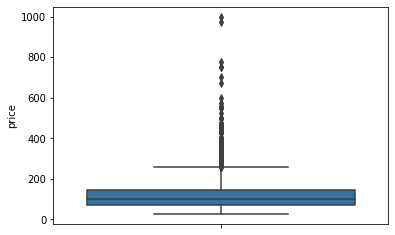

In [21]:
sns.boxplot(y=listings.price)
plt.show()

In [22]:
listings.price.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.0     25.0
0.1     52.0
0.2     66.0
0.3     79.0
0.4     90.0
0.5     99.0
0.6    115.0
0.7    130.0
0.8    151.0
0.9    200.0
1.0    999.0
Name: price, dtype: float64

In [23]:
len(listings[listings.price<400]), len(listings[listings.price>=200])

(2619, 298)

In [24]:
listings=listings[listings.price<400]

In [45]:
2619/2655

0.9864406779661017

## Datos de salida

In [25]:
dataset=listings
print('Las dimensiones del conjunto de salida son', dataset.shape)

Las dimensiones del conjunto de salida son (2619, 80)


## Dividiendo los datos en entrenamiento y testing

In [26]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [27]:
train_dataset.head()

,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,...,Queen Anne,Rainier Valley,Seward Park,University District,West Seattle,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
1657,100.0,100.0,47.606701,-122.328703,3,1.0,1.0,1.0,129.0,300.0,...,0,0,0,0,0,0,0,0,0,1
972,100.0,100.0,47.592066,-122.293565,4,1.0,2.0,2.0,105.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1383,100.0,100.0,47.613486,-122.349286,4,1.0,0.0,2.0,100.0,95.0,...,0,0,0,0,0,0,0,0,0,1
2106,100.0,100.0,47.584671,-122.314645,6,2.0,2.0,2.0,149.0,750.0,...,0,0,0,0,0,0,0,0,0,1
2620,100.0,100.0,47.615310,-122.314525,4,1.0,1.0,2.0,100.0,200.0,...,0,0,0,0,0,0,0,0,0,1


## Descriptivo

In [28]:
train_stats = train_dataset.describe()
train_stats.pop("price")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
host_response_rate,2095.0,95.361814,10.808124,25.000000,98.000000,100.000000,100.000000,100.000000
host_acceptance_rate,2095.0,99.952267,2.184781,0.000000,100.000000,100.000000,100.000000,100.000000
latitude,2095.0,47.628326,0.042761,47.507284,47.607946,47.622768,47.663120,47.733358
longitude,2095.0,-122.332774,0.031703,-122.417219,-122.353469,-122.329121,-122.310792,-122.254189
accommodates,2095.0,3.349881,1.915171,1.000000,2.000000,3.000000,4.000000,16.000000
...,...,...,...,...,...,...,...,...
Airbed,2095.0,0.006683,0.081493,0.000000,0.000000,0.000000,0.000000,1.000000
Couch,2095.0,0.002864,0.053452,0.000000,0.000000,0.000000,0.000000,1.000000
Futon,2095.0,0.017661,0.131748,0.000000,0.000000,0.000000,0.000000,1.000000
Pull-out Sofa,2095.0,0.014320,0.118834,0.000000,0.000000,0.000000,0.000000,1.000000


## Separando caracteristicas y etiquetas

In [29]:
train_labels = train_dataset.pop('price')
test_labels = test_dataset.pop('price')

## Normalizando

In [30]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [31]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(normed_test_data)

,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,comments_polarity,a few days or more,within a day,within a few hours,within an hour,identity_verified_f,identity_verified_t,superhost_f,superhost_t,cancellation_flexible,cancellation_moderate,cancellation_strict,guest_pro_pic_f,guest_pro_pic_t,inst_book_f,inst_book_t,guest_phone_ver_f,guest_phone_ver_t,Apartment,Bed & Breakfast,Bungalow,Cabin,Camper/RV,Condominium,Dorm,House,Loft,Other,Townhouse,Treehouse,Entire home/apt,Private room,Shared room,Ballard,Beacon Hill,Capitol Hill,Cascade,Central Area,Delridge,Downtown,Interbay,Lake City,Magnolia,Northgate,Other neighborhoods,Queen Anne,Rainier Valley,Seward Park,University District,West Seattle,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
0,0.059047,0.021848,0.186225,-1.206532,0.339458,-0.404637,-0.303580,-0.669452,-0.668614,-0.960235,0.249724,-0.366224,-0.065339,-0.700906,-0.332737,4.308232,0.070294,0.519731,0.559487,0.355703,0.337681,-0.963198,0.723788,0.926347,-0.186606,-0.098153,-0.422143,1.550921,-1.095471,-0.447747,0.447747,0.593563,-0.593563,-0.559024,1.323677,-0.813869,0.338969,-0.338969,0.473628,-0.473628,0.374672,-0.374672,1.095471,-0.095644,-0.061898,-0.090427,-0.05358,-0.149797,-0.030905,-0.908906,-0.107625,-0.087706,-0.165684,-0.021848,0.703650,-0.651152,-0.18588,-0.271612,-0.180313,-0.404735,-0.132196,-0.33104,-0.148124,-0.424495,-0.03786,-0.114236,-0.118449,-0.14125,-0.516236,3.666314,-0.220285,-0.11636,-0.187249,-0.223833,-0.082002,-0.05358,-0.134052,-0.120503,0.208101
7,0.429139,0.021848,0.276762,-1.358908,-0.704836,-0.404637,-0.303580,-0.669452,0.074745,-0.426131,-0.555155,-0.661361,-0.019619,-1.400739,0.375862,3.484251,0.373937,0.519731,0.559487,0.355703,0.337681,-0.963198,0.723788,1.279915,-0.489717,-0.098153,-0.422143,-0.644470,0.912413,-0.447747,0.447747,-1.683937,1.683937,-0.559024,-0.755111,1.228113,-2.948715,2.948715,0.473628,-0.473628,-2.667725,2.667725,-0.912413,-0.095644,-0.061898,11.053368,-0.05358,-0.149797,-0.030905,-0.908906,-0.107625,-0.087706,-0.165684,-0.021848,-1.420482,1.535007,-0.18588,-0.271612,-0.180313,-0.404735,-0.132196,-0.33104,-0.148124,-0.424495,-0.03786,-0.114236,-0.118449,-0.14125,-0.516236,3.666314,-0.220285,-0.11636,-0.187249,-0.223833,-0.082002,-0.05358,-0.134052,-0.120503,0.208101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3803,0.151570,0.021848,0.767163,-0.519295,6.605218,3.956031,3.372726,7.695370,0.570318,1.176182,8.298513,0.814325,-0.065339,0.784773,0.641587,-0.611421,0.070294,0.519731,0.559487,0.355703,0.337681,0.616990,0.723788,0.888847,1.932192,-0.098153,-0.422143,1.550921,-1.095471,-0.447747,0.447747,0.593563,-0.593563,-0.559024,1.323677,-0.813869,0.338969,-0.338969,0.473628,-0.473628,0.374672,-0.374672,-0.912413,-0.095644,-0.061898,-0.090427,-0.05358,-0.149797,-0.030905,1.099699,-0.107625,-0.087706,-0.165684,-0.021848,0.703650,-0.651152,-0.18588,-0.271612,-0.180313,-0.404735,-0.132196,-0.33104,-0.148124,-0.424495,-0.03786,-0.114236,-0.118449,-0.14125,1.936176,-0.272623,-0.220285,-0.11636,-0.187249,-0.223833,-0.082002,-0.05358,-0.134052,-0.120503,0.208101
3810,0.429139,0.021848,0.605202,-0.625469,0.861604,-0.404637,0.921855,1.189397,0.074745,0.855719,1.859482,2.290010,-0.019619,-1.387055,-0.421312,-0.587186,-0.385170,-0.872643,-2.051038,0.355703,0.337681,0.616990,-1.967137,-0.418282,-1.498406,-0.098153,-0.422143,-0.644470,0.912413,-0.447747,0.447747,0.593563

# El modelo

### Construye el modelo

In [32]:
#def build_model(): 
#  model = keras.Sequential([
#    layers.Dense(16, activation='relu', input_shape=[len(train_dataset.keys())]),
#    layers.Dense(1)
#  ])

#  optimizer=Adam(0.001)#Revisar, ensayar Adam

#  model.compile(loss='mse',
 #               optimizer=optimizer,
 # #              metrics=['mae', 'mse'])
  #return model

In [33]:
def build_model(): 
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[len(train_dataset.keys())]),
    #layers.Dense(16, activation='relu'),
    layers.Dense(1)
  ])

  optimizer=Adam(0.001)#Revisar, ensayar Adam

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [34]:
model = build_model()

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                1280      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________


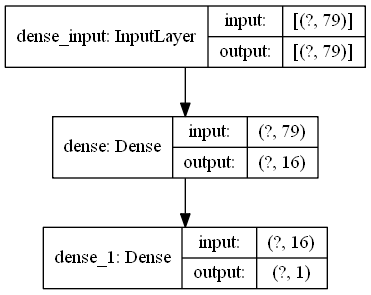

In [36]:
plot_model(model, to_file='regresion_model_keras.png', show_shapes=True)

In [37]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 1.446425  ],
       [-0.36680222],
       [ 0.43788266],
       [-0.90153635],
       [ 0.2632197 ],
       [-0.27887928],
       [-1.850767  ],
       [ 0.06238301],
       [-0.18683633],
       [ 0.26253337]], dtype=float32)

### Entrenamiento del modelo

In [38]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 200

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................

In [39]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
195,965.292225,21.795761,965.292236,1524.177780,26.000364,1524.177856,195
196,964.845706,21.779957,964.845825,1532.792700,26.025909,1532.792847,196
197,966.244316,21.785473,966.244263,1539.898406,26.046217,1539.898438,197
198,964.725266,21.780546,964.725464,1547.784701,26.051149,1547.784790,198
199,963.240750,21.781889,963.240723,1554.555674,26.055141,1554.555542,199


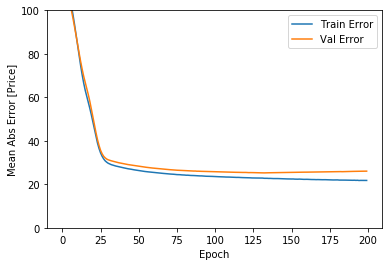

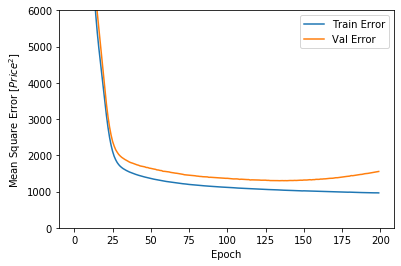

In [40]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Price]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,100])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Price^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,6000])
  plt.legend()
  plt.show()


plot_history(history)


....................................................................................................
...............................

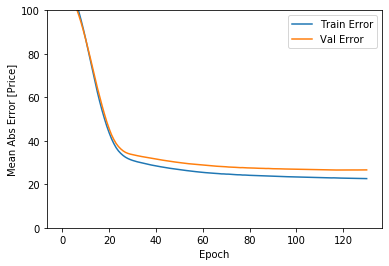

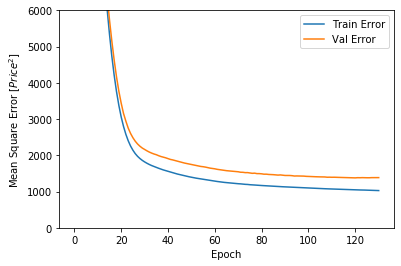

In [41]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [42]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

524/524 - 0s - loss: 1235.9704 - mae: 25.1593 - mse: 1235.9703
Testing set Mean Abs Error: 25.16


## Predicciones

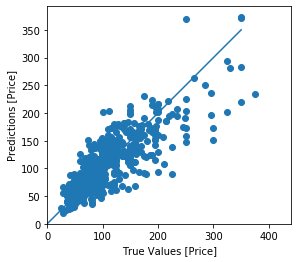

In [43]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 350], [-100, 350]) #El modelo subestima para precios mayores a 200 dolares

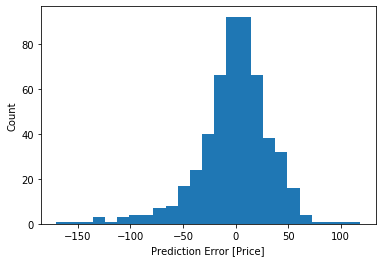

In [44]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Price]")
_ = plt.ylabel("Count")